In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import nltk
import pickle
from nltk.util import bigrams
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from model import LSTMGenerator
from main import encode_to_one_hot

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
xlsx = pd.read_excel("./data/grants.xlsx", engine='openpyxl', sheet_name=[0, 1, 2, 3, 4])
df = pd.concat(xlsx, ignore_index=True).drop('No', axis=1).dropna()

In [4]:
df.head()

,IKT,FIO,Points,University
0,903300067.0,РАХМЕТУЛЛА АСАНӘЛІ,140.0,302
1,902300822.0,Жамашев Ержан Жеңісұлы,140.0,302
2,903300006.0,ЗАМАНБЕК МУХАММЕД ЖЕҢІСҰЛЫ,140.0,302
3,903300043.0,ЖҰМАЖАНОВ МИРАС МАРАТҰЛЫ,140.0,302
4,903300051.0,Тлеулесов Максут Кайратович,140.0,83


In [5]:
df['FIO'] = df['FIO'].apply(lambda x: x.title())

In [6]:
df.head()

,IKT,FIO,Points,University
0,903300067.0,Рахметулла Асанәлі,140.0,302
1,902300822.0,Жамашев Ержан Жеңісұлы,140.0,302
2,903300006.0,Заманбек Мухаммед Жеңісұлы,140.0,302
3,903300043.0,Жұмажанов Мирас Маратұлы,140.0,302
4,903300051.0,Тлеулесов Максут Кайратович,140.0,83


In [7]:
preprocess_text = lambda x: [char for char in x.strip()]

In [8]:
df['FIO'] = df['FIO'].apply(preprocess_text)

In [9]:
df.head()

,IKT,FIO,Points,University
0,903300067.0,"[Р, а, х, м, е, т, у, л, л, а, , А, с, а, н, ...",140.0,302
1,902300822.0,"[Ж, а, м, а, ш, е, в, , Е, р, ж, а, н, , Ж, ...",140.0,302
2,903300006.0,"[З, а, м, а, н, б, е, к, , М, у, х, а, м, м, ...",140.0,302
3,903300043.0,"[Ж, ұ, м, а, ж, а, н, о, в, , М, и, р, а, с, ...",140.0,302
4,903300051.0,"[Т, л, е, у, л, е, с, о, в, , М, а, к, с, у, ...",140.0,83


In [10]:
char2idx = {'PAD': 0, 'SOS': 1, 'EOS': 2}

In [11]:
idx = 3
def fill_char2idx(chars, char2idx):
    global idx
    for char in chars:
        if char not in char2idx:
            char2idx[char] = idx
            idx += 1

In [12]:
df['FIO'].apply(lambda x: fill_char2idx(x, char2idx))
None

In [13]:
idx2char = {v: k for k, v in char2idx.items()}

In [14]:
df['FIO'] = df['FIO'].apply(lambda x: [char2idx['SOS']] + [char2idx[char] for char in x] + [char2idx['EOS']])

In [15]:
df.head()

,IKT,FIO,Points,University
0,903300067.0,"[1, 3, 4, 5, 6, 7, 8, 9, 10, 10, 4, 11, 12, 13...",140.0,302
1,902300822.0,"[1, 17, 4, 6, 4, 18, 7, 19, 11, 20, 21, 22, 4,...",140.0,302
2,903300006.0,"[1, 26, 4, 6, 4, 14, 27, 7, 28, 11, 29, 9, 5, ...",140.0,302
3,903300043.0,"[1, 17, 24, 6, 4, 22, 4, 14, 31, 19, 11, 29, 3...",140.0,302
4,903300051.0,"[1, 33, 10, 7, 9, 10, 7, 13, 31, 19, 11, 29, 4...",140.0,83


In [16]:
df = df['FIO'].values

In [17]:
np.random.shuffle(df)

def generate_batch(df, vocab_size):
    random_name = df[np.random.randint(0, len(df))]

    name_bigrams = list(bigrams(random_name))

    for (curr_char, next_char) in name_bigrams:
        yield encode_to_one_hot(curr_char, vocab_size), torch.tensor([next_char], dtype=torch.long)

In [18]:
vocab_size = len(char2idx)
hidden_dim = 256
dropout = 0.2

In [19]:
model = LSTMGenerator(vocab_size, hidden_dim, dropout)
model.to(device)

LSTMGenerator(
  (lstm): LSTM(83, 256)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=83, bias=True)
)

In [20]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [21]:
def train(model, batch, criterion, prev_state):
    
    curr_char, next_char = batch

    curr_char = curr_char.to(device)
    next_char = next_char.to(device)

    prediction, prev_state = model(curr_char, prev_state)

    loss = criterion(prediction, next_char)
    
    return loss, prev_state

In [22]:
num_epochs = 15000
losses = []
l = 0.0

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    train_loss = 0.0
    prev_state = model.init_state(device)
    loader = list(generate_batch(df, vocab_size))

    model.train()
    for batch in loader:
        batch_loss, prev_state = train(model, batch, criterion, prev_state)
        train_loss += batch_loss

    train_loss.backward()
    optimizer.step()

    l += train_loss.item() / len(loader)

    if epoch % 100 == 0:
        losses.append(l / 100)
        print(f'Epoch: {epoch} | Loss: {(l / 100.0):.4}')
        l = 0.0

Epoch: 100 | Loss: 3.643
Epoch: 200 | Loss: 3.426
Epoch: 300 | Loss: 3.301
Epoch: 400 | Loss: 3.007
Epoch: 500 | Loss: 2.732
Epoch: 600 | Loss: 2.551
Epoch: 700 | Loss: 2.413
Epoch: 800 | Loss: 2.259
Epoch: 900 | Loss: 2.228
Epoch: 1000 | Loss: 2.132
Epoch: 1100 | Loss: 2.197
Epoch: 1200 | Loss: 2.119
Epoch: 1300 | Loss: 2.065
Epoch: 1400 | Loss: 2.039
Epoch: 1500 | Loss: 2.074
Epoch: 1600 | Loss: 2.04
Epoch: 1700 | Loss: 1.992
Epoch: 1800 | Loss: 1.956
Epoch: 1900 | Loss: 1.949
Epoch: 2000 | Loss: 1.89
Epoch: 2100 | Loss: 1.936
Epoch: 2200 | Loss: 1.931
Epoch: 2300 | Loss: 1.876
Epoch: 2400 | Loss: 1.883
Epoch: 2500 | Loss: 1.884
Epoch: 2600 | Loss: 1.883
Epoch: 2700 | Loss: 1.869
Epoch: 2800 | Loss: 1.918
Epoch: 2900 | Loss: 1.845
Epoch: 3000 | Loss: 1.836
Epoch: 3100 | Loss: 1.765
Epoch: 3200 | Loss: 1.787
Epoch: 3300 | Loss: 1.813
Epoch: 3400 | Loss: 1.762
Epoch: 3500 | Loss: 1.765
Epoch: 3600 | Loss: 1.784
Epoch: 3700 | Loss: 1.786
Epoch: 3800 | Loss: 1.748
Epoch: 3900 | Loss: 1.7

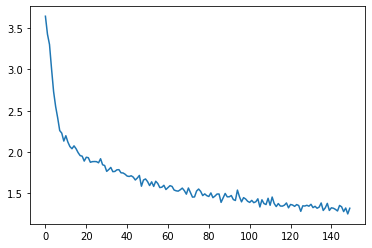

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(losses)

In [24]:
torch.save(model.state_dict(), 'model.pt')

In [25]:
with open('char2idx.pkl', 'wb') as f:
    pickle.dump(char2idx, f, pickle.HIGHEST_PROTOCOL)